<a href="https://colab.research.google.com/github/Stefano-Previti/Curiosity_driven_exploration_by_self_supervised_prediction/blob/main/Curiosity_driven_exploration_by_Self_supervised_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**▶INITIAL SETUP OF THE ENVIROMENT**

In [ ]:
# Super Mario environment for OpenAI Gym
!pip install gym-super-mario-bros

# Backend for NES emulation
!pip install nes-py

# PyTorch for building and training neural networks
!pip install torch torchvision

# TensorBoard for monitoring training progress
!pip install tensorboard

# Visualization tools for plotting and analysis
!pip install matplotlib


In [ ]:
!pip install pyvirtualdisplay


In [4]:

from pyvirtualdisplay import Display
import gym
from gym_super_mario_bros import make
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from gym.wrappers import FrameStack
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import cv2
import random
import time
from gym.spaces import Box

# Wrapper to skip frames
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, sum rewards, and return the last observation"""
        total_reward = 0.0
        done = False
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


# Wrapper to convert frames to grayscale
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        return cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)


# Wrapper to resize frames
class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        self.shape = (shape, shape) if isinstance(shape, int) else tuple(shape)
        obs_shape = self.shape + (1,)  # Add channel dimension for grayscale
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        observation = cv2.resize(observation, self.shape, interpolation=cv2.INTER_AREA)
        return np.expand_dims(observation, axis=-1)  # Add channel dimension


# Updated Super Mario Environment Class
class SuperMarioEnvironment:
    def __init__(self, level_id="SuperMarioBros-1-1-v0", frame_size=(42, 42), skip_frames=4):
        """Initialize the Super Mario Environment."""
        self.level_id = level_id
        self.frame_size = frame_size
        self.skip_frames = skip_frames
        self.env = None
        self.actions = COMPLEX_MOVEMENT

    def create_environment(self):
        """Create the Super Mario environment with frame skipping, grayscale, and resizing."""
        self.env = make(self.level_id)
        self.env = SkipFrame(self.env, skip=self.skip_frames)  # Skip frames
        self.env = GrayScaleObservation(self.env)  # Convert to grayscale
        self.env = ResizeObservation(self.env, shape=self.frame_size)  # Resize frames
        self.env = FrameStack(self.env, num_stack=4)  # Stack frames
        print(f"Environment for {self.level_id} created.")

    def reset_environment(self):
        """Reset the environment and return the initial state."""
        if self.env is None:
            raise ValueError("Environment not created. Call create_environment() first.")
        return self.env.reset()

    def step(self, action):
        """Take an action in the environment."""
        if self.env is None:
            raise ValueError("Environment not created. Call create_environment() first.")
        return self.env.step(action)

    def render_frame(self):
        """Render the current frame in RGB format."""
        if self.env is None:
            raise ValueError("Environment not created. Call create_environment() first.")
        return self.env.render(mode='rgb_array')

    def close(self):
        """Close the environment."""
        if self.env:
            self.env.close()
    @property
    def action_space(self):
        if self.env is None:
            raise ValueError("Environment not created. Call create_environment() first.")
        return self.env.action_space


In [ ]:
# Create the game environment
env = SuperMarioEnvironment(frame_size=(42, 42), skip_frames=4)
env.create_environment()

# Get frame dimensions
state = env.reset_environment()
frame = env.render_frame()
frame_height, frame_width, _ = frame.shape

# Configure video writer
video_filename = "super_mario.mp4"
fps = 20  # Frames per second
video_writer = cv2.VideoWriter(
    video_filename,
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (frame_width, frame_height),
)

# Frame buffer
frame_buffer = []
frame_time = 1 / fps  # Time per frame

try:
    start_time = time.time()
    for step in range(1000):  # Number of steps to simulate
        # Perform a random action from the action space
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)

        # Capture frame and add to buffer
        frame = env.render_frame()  # Get the current rendered frame
        frame_buffer.append(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))

        # Handle resets
        if done:
            print(f"Game Over at step {step}. Restarting...")
            state = env.reset_environment()
            continue  # Skip writing frames during reset

        # Synchronize frame timing
        elapsed_time = time.time() - start_time
        if elapsed_time < frame_time:
            time.sleep(frame_time - elapsed_time)
        start_time = time.time()

    # Write all buffered frames to the video file
    for frame in frame_buffer:
        video_writer.write(frame)

finally:
    env.close()
    video_writer.release()
    print(f"Video saved as {video_filename}")



**▶ICM**


 Intrinsic Curiosity Module (ICM) encodes the states into the
 features that are trained to predict a_t (i.e. inverse dynamics model). The forward model takes as inputs f(s_t) and a_t
 and predicts the feature representation of s_t+1. The prediction error in the feature space is used as the curiosity based intrinsic
 reward signal.

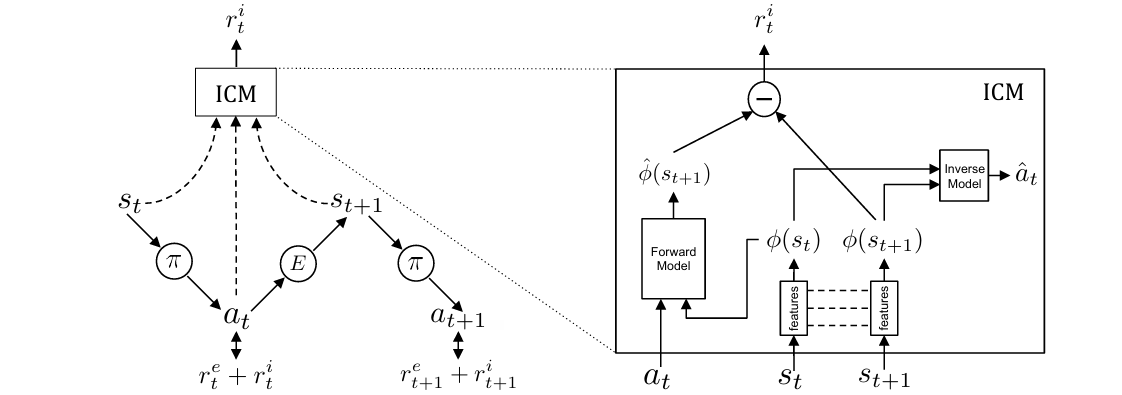

The overall optimization can be senn as:


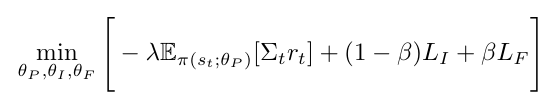

Where the reward is the sum of the extrinsic reward with the intrinsic one, the Li term is the loss function that measures the discrepancy between the predicted and actual actions and the Lf term is the MSE between the prediction of th feature encoding of the state at time step t+1 and the real value.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#ICM
class ICM(nn.Module):
    def __init__(self, input_channels, num_actions):
        super(ICM, self).__init__()
        self.num_actions = num_actions

        # Feature extractor
        self.feature_extractor = nn.Sequential(
          nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),
          nn.ELU(inplace=False),
          nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
          nn.ELU(inplace=False),
          nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
          nn.ELU(inplace=False),
          nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
          nn.ELU(inplace=False),
      )

        self.feature_dim = 288

        #Inverse model
        self.inverse_model = nn.Sequential(
            nn.Linear(self.feature_dim * 2, 256),
            nn.ReLU(inplace=False),
            nn.Linear(256, self.num_actions),
        )

        #Forward model
        self.forward_model = nn.Sequential(
            nn.Linear(self.feature_dim + self.num_actions, 256),
            nn.ReLU(inplace=False),
            nn.Linear(256, self.feature_dim),
      )

    def forward(self, state, next_state, action_onehot):
        state = state.to(device)
        next_state = next_state.to(device)
        action_onehot = action_onehot.to(device)

        s_features = self.feature_extractor(state)
        s_features = s_features.view(s_features.size(0), -1)  #[B,288]

        ns_features = self.feature_extractor(next_state)
        ns_features = ns_features.view(ns_features.size(0), -1)

        # Inverse
        inv_input = torch.cat([s_features, ns_features], dim=1) #[B,288*2]
        inverse_pred = self.inverse_model(inv_input)  #[B, num_actions]

        # Forward
        forw_input = torch.cat([s_features, action_onehot], dim=1)  #[B,288 + n_actions]
        forward_pred = self.forward_model(forw_input)               # [B,288]

        return inverse_pred, forward_pred, ns_features

    def compute_icm_loss(self, states, next_states, actions,
                         rewards, rewards_int, beta, lambda_):
        # Convert integer actions to one-hot with a fixed dimension
        one_hot_actions = F.one_hot(actions, num_classes=self.num_actions).float().to(device)

        inv_pred, forw_pred, ns_feats = self(states, next_states, one_hot_actions)

        # Inverse model loss
        inv_loss = F.cross_entropy(inv_pred, actions)

        # Forward model loss
        forw_loss = F.mse_loss(forw_pred, ns_feats)

        # Summation of extrinsic + intrinsic reward
        total_reward = torch.sum(torch.FloatTensor(rewards).to(device)) + \
                       torch.sum(torch.FloatTensor(rewards_int).to(device))

        # ICM loss formula
        icm_loss = -(lambda_ * total_reward) + (1 - beta)*inv_loss + beta*forw_loss
        return icm_loss

**▶A3C**

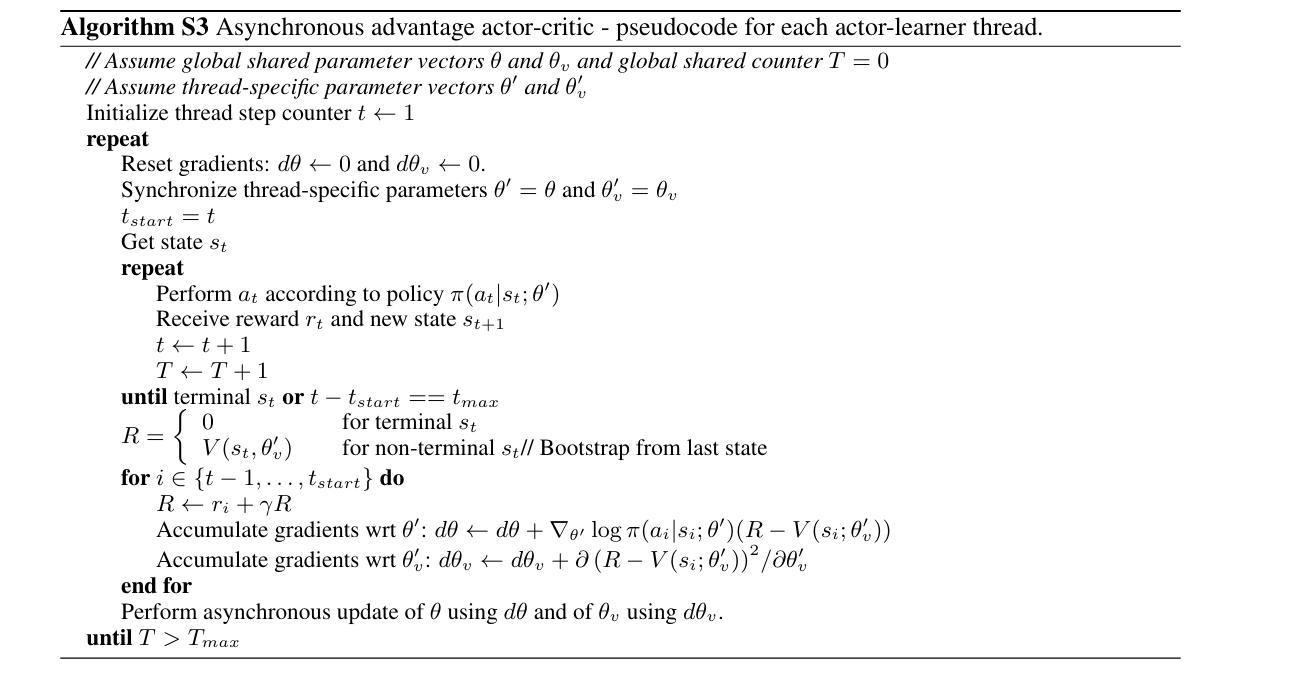

⏰
The loss adapted for the project has an entropy term to encourage the exploration (as suggested by the original paper of A3C) and the return is computed as the sum of the extrinsic rewards with the intrinsic ones.

In [ ]:
import os
import threading
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.multiprocessing import Process, Value, Lock
from google.colab import drive

#Mounting drive
drive.mount('/content/drive')

#Global lock so that updates to the global model happen one at a time
global_update_lock = Lock()

# ACTOR CRITIC
class ActorCritic(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(ActorCritic, self).__init__()
        # Convolutional part
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(inplace=False),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(inplace=False),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(inplace=False),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ELU(inplace=False),
        )

        conv_out_size = 288

        # LSTM
        self.lstm = nn.LSTM(conv_out_size, 256, batch_first=True)

        # Policy and Value heads
        self.policy = nn.Linear(256, n_actions)
        self.value = nn.Linear(256, 1)

    def forward(self, x, hx=None):
        x = x.clone().to(device)
        batch_size = x.size(0)
        x = self.conv(x).view(batch_size, -1)  # [B, 288]
        x = x.unsqueeze(1)                     #[B,1,288]  (seq_len=1)

        if hx is None or hx[0].size(1) != batch_size:
          hx = (
              torch.zeros(1, batch_size, 256, device=x.device),  # hidden state
              torch.zeros(1, batch_size, 256, device=x.device)   # cell state
          )

        lstm_out, hx = self.lstm(x, hx)
        lstm_out = lstm_out.squeeze(1)        # [B,256]

        policy_logits = self.policy(lstm_out) # [B, n_actions]
        value = self.value(lstm_out)          # [B,1]
        return policy_logits, value, hx

# WORKER (A3C + ICM)
class Worker(Process):
    def __init__(self, global_model, icm_model, optimizer,
                 icm_optimizer, global_counter, global_max_steps,
                 gamma, beta, lambda_):
        super(Worker, self).__init__()

        # Create environment for every worker
        self.env = SuperMarioEnvironment(level_id="SuperMarioBros-1-1-v3",
                                          frame_size=(42,42),
                                          skip_frames=4)
        self.env.create_environment()

        # Local copy of ActorCritic
        self.local_model = ActorCritic(self.env.env.observation_space.shape, self.env.env.action_space.n).to(device)
        self.icm_model = icm_model.to(device)
        self.global_model = global_model  # shared ActorCritic (global)

        self.optimizer = optimizer
        self.icm_optimizer = icm_optimizer
        self.global_counter = global_counter
        self.global_max_steps = global_max_steps
        self.gamma = gamma
        self.beta = beta
        self.lambda_ = lambda_
        self.episode_counter = 0

    def run(self):
        while self.global_counter.value < self.global_max_steps:
            obs = np.array(self.env.reset_environment(), dtype=np.float32)
            state = torch.from_numpy(obs).reshape(1,4,42,42).to(device)  # [1,4,42,42]
            done = False
            hx = None

            states_list = []
            next_states_list = []
            actions_list = []
            rewards_list = []
            rewards_int_list = []

            total_reward = 0.0

            while not done:
                logits, value, hx = self.local_model(state, hx)
                dist = Categorical(logits=logits)
                action = dist.sample()

                next_obs, reward, done, info = self.env.step(action.item())
                next_obs = np.array(next_obs, dtype=np.float32)
                next_state = torch.from_numpy(next_obs).reshape(1,4,42,42).to(device)

                next_obs = np.array(next_obs, dtype=np.float32)
                next_state = torch.from_numpy(next_obs).reshape(1, 4, 42, 42).to(device)

                # Intrinsic reward (forward model error)
                with torch.no_grad():
                    one_hot_act = F.one_hot(action, num_classes=self.env.env.action_space.n).float()
                    _, forward_pred, ns_features = self.icm_model(state, next_state, one_hot_act)
                    intr_reward = 0.1 * ((forward_pred - ns_features)**2).sum().item()

                # Track distance
                x_pos = info['x_pos']
                total_distance = x_pos

                states_list.append(state)
                next_states_list.append(next_state)
                actions_list.append(action)
                rewards_list.append(reward)
                rewards_int_list.append(intr_reward)

                total_reward = total_reward + reward
                state = next_state

                # Update global counter
                with self.global_counter.get_lock():
                    self.global_counter.value = self.global_counter.value + 1

                # If done or we reached batch size
                if done or len(rewards_list) >= 16:
                    a3c_loss, icm_loss =self.update_global(
                        states_list,
                        next_states_list,
                        actions_list,
                        rewards_list,
                        rewards_int_list,
                        next_state if not done else None,
                        hx
                    )

                    # Clear lists
                    states_list, next_states_list = [], []
                    actions_list, rewards_list, rewards_int_list = [], [], []

                if done:
                    self.episode_counter = self.episode_counter + 1
                    print(f"Episode {self.episode_counter}: Cumulative Reward = {total_reward:.2f}, "
                      f"Distance Traveled = {total_distance}, "
                      f"A3C Loss = {a3c_loss:.4f}, ICM Loss = {icm_loss:.4f}")

                    # Save and load checkpoint periodically
                    if self.episode_counter % 10 == 0:
                        self.save_checkpoint()
                        self.load_checkpoint()

    def update_global(self, states, next_states, actions,
                      rewards, rewards_int, next_state, hx):
        # Bootstrap value if the episode is not done
        if next_state is not None:
            with torch.no_grad():
                _, next_val, _ = self.local_model(next_state, hx)
                R = next_val.item()
        else:
            R = 0.0

        # Calculate returns
        returns = []
        combined_rewards = [r + ri for r, ri in zip(rewards, rewards_int)]
        for r in reversed(combined_rewards):
            R = r + self.gamma * R
            returns.insert(0, R)

        # Normalize returns
        returns_t = torch.FloatTensor(returns).to(device)
        std = returns_t.std()
        std = torch.clamp(std, min=1e-8)
        returns_t = (returns_t - returns_t.mean()) / (std)

        states_t = torch.cat(states, dim=0).to(device)
        next_states_t = torch.cat(next_states, dim=0).to(device)
        actions_t = torch.stack(actions, dim=0).squeeze(-1).to(device)

        # A3C forward (local)
        logits, values, _ = self.local_model(states_t, hx)
        dist = Categorical(logits=logits)

        advantage = returns_t - values.squeeze(1)

        # Loss A3C
        policy_loss = -(dist.log_prob(actions_t) * advantage.detach()).mean()
        value_loss = advantage.pow(2).mean()
        entropy_loss = dist.entropy().mean()
        a3c_loss = policy_loss + 0.5*value_loss - 0.01*entropy_loss

        # ICM loss
        icm_loss = self.icm_model.compute_icm_loss(
            states_t, next_states_t, actions_t,
            rewards, rewards_int,
            self.beta, self.lambda_
          )


        # Update global model under a lock
        with global_update_lock:
            # Zero local grads
            self.optimizer.zero_grad()
            self.icm_optimizer.zero_grad()

            # Backward on local
            with torch.autograd.set_detect_anomaly(True):
              a3c_loss.backward()
              icm_loss.backward()

            # Clip gradients here
            torch.nn.utils.clip_grad_norm_(self.local_model.parameters(), max_norm=0.5)
            torch.nn.utils.clip_grad_norm_(self.icm_model.parameters(), max_norm=0.5)

            # Copy local grads to global
            for g_param, l_param in zip(self.global_model.parameters(), self.local_model.parameters()):
                g_param._grad = l_param.grad

            self.optimizer.step()

            # Update ICM
            self.icm_optimizer.step()

            # Now pull the updated global weights back to local
            self.local_model.load_state_dict(self.global_model.state_dict())

        return a3c_loss.item(), icm_loss.item()

    def save_checkpoint(self):
        # Example checkpoint path
        ckpt_dir = "/content/drive/My Drive/Mario_Checkpoints"
        os.makedirs(ckpt_dir, exist_ok=True)

        actor_path = os.path.join(ckpt_dir, "actor_critic_model.pt")
        icm_path = os.path.join(ckpt_dir, "icm_model.pt")

        torch.save(self.global_model.state_dict(), actor_path)
        torch.save(self.icm_model.state_dict(), icm_path)
        print(f"Checkpoint saved at episode {self.episode_counter}")

    def load_checkpoint(self):
        # Example checkpoint path
        ckpt_dir = "/content/drive/My Drive/Mario_Checkpoints"
        actor_path = os.path.join(ckpt_dir, "actor_critic_model.pt")
        icm_path = os.path.join(ckpt_dir, "icm_model.pt")

        if os.path.exists(actor_path) and os.path.exists(icm_path):
            self.global_model.load_state_dict(torch.load(actor_path))
            self.icm_model.load_state_dict(torch.load(icm_path))
            print(f"Checkpoint loaded at episode {self.episode_counter}")
        else:
            print(f"No checkpoint found to load at episode {self.episode_counter}")



#TRAINING
def train_mario(global_max_steps=1_000_000, n_threads=4, gamma=0.99, beta=0.2, lambda_=0.1):
    # Create environment
    mario_env = SuperMarioEnvironment(level_id="SuperMarioBros-1-1-v3",
                                      frame_size=(42,42),
                                      skip_frames=4)
    mario_env.create_environment()

    # Extract shapes
    obs_space = mario_env.env.observation_space
    act_space = mario_env.env.action_space

    # Global models
    global_model = ActorCritic(obs_space.shape, act_space.n).to(device)
    global_model.share_memory()

    icm_model = ICM(obs_space.shape[0], act_space.n).to(device)
    icm_model.share_memory()

    #Optimizers
    optimizer = optim.Adam(global_model.parameters(), lr=1e-4)
    icm_optimizer = optim.Adam(icm_model.parameters(), lr=1e-4)

    #Multiprocessing counter
    global_counter = Value('i', 0)

    # Worker threads
    workers = []
    for _ in range(n_threads):
        w = Worker( global_model, icm_model, optimizer,
                   icm_optimizer, global_counter, global_max_steps,
                   gamma, beta, lambda_)
        w.start()
        workers.append(w)

    # Join threads
    for w in workers:
        w.join()

    print("Training finished.")

if __name__ == "__main__":
    train_mario()


**▶TEST**

In [ ]:
import torch
from torch.distributions import Categorical
import matplotlib.pyplot as plt

# Test function
def test(global_model, env, episodes=5):
    # Set the model to evaluation mode
    global_model.eval()

    rewards_per_episode = []
    distances_per_episode = []  # To store distances per episode

    for episode in range(episodes):
        state = torch.FloatTensor(env.reset_environment()).reshape(1, 4, 42, 42).to(device)  # Reset environment
        done = False
        hx = None
        total_reward = 0
        initial_x_pos = 0
        total_distance = 0

        while not done:
            # Get the action from the trained policy
            with torch.no_grad():
                logits, _, hx = global_model(state, hx)
                dist = Categorical(logits=logits)
                action = dist.sample()

            # Perform the action in the environment
            next_state, reward, done, info = env.step(action.item())
            next_state = torch.FloatTensor(next_state).reshape(1, 4, 42, 42).to(device)

            # Track distance
            x_pos = info['x_pos']
            total_distance = x_pos

            # Accumulate extrinsic reward
            total_reward += reward
            state = next_state

        rewards_per_episode.append(total_reward)
        distances_per_episode.append(total_distance)
        print(f"Episode {episode + 1}/{episodes}: Total Reward = {total_reward:.2f}, Distance Traveled = {total_distance}")

    # Plot the rewards and distances
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(rewards_per_episode, label='Extrinsic Reward', marker='o')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('Extrinsic Rewards on New Level')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(distances_per_episode, label='Distance Traveled', marker='o', color='orange')
    plt.xlabel('Episodes')
    plt.ylabel('Distance')
    plt.title('Distances Traveled on New Level')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Create a new environment/level for testing
    level_id = "SuperMarioBros-1-2-v3"  # Specify the new level
    new_mario_env = SuperMarioEnvironment(level_id=level_id, frame_size=(42, 42), skip_frames=4)
    new_mario_env.create_environment()  # Initialize the environment

    # Get observation space and action space from the environment
    observation_space = new_mario_env.env.observation_space
    action_space = new_mario_env.env.action_space

    # Load the trained Actor-Critic model
    global_model = ActorCritic(observation_space.shape, action_space.n).to(device)

    # Specify the checkpoint file path
    checkpoint_path = "/content/drive/My Drive/Mario_Checkpoints/actor_critic_model.pt"

    # Load the model weights
    global_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    print(f"Model loaded successfully from {checkpoint_path}")

    # Test the model on the new level
    test(global_model, new_mario_env, episodes=5)

    # Close the environment after testing
    new_mario_env.close()

